In [195]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-03-BIGDATA/master/init.py
import init; init.init(force_download=False); 
from IPython.display import Image

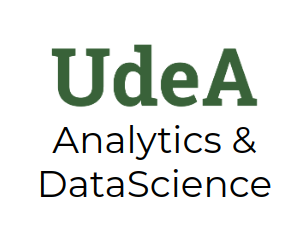

In [184]:
Image("local/imgs/udea-datascience.png")

In [196]:
#Instalación
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz 
!pip install -q findspark

#Variables de Entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

#SparkContext
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()

#**RDD**



Un RDD (Dataset Distribuido Resiliente) es una colección de elementos que es tolerante a fallos y que es capaz de operar en paralelo.

Se considera como la principal abstracción de datos de Spark, definido desde la primera versión, y permite que los datos se puedan particionar y distribuir en los nodos del clúster.

Estas son las principales características de los RDD:
* Inmutable: Una vez creado NO puede ser modificado
* Tolerancia a fallas: Ya que los RDD están particionados y distribuidos en los nodos del clúster, si un nodo falla se puede recuperar los datos consultando otro nodo
* Evaluación perezosa: Las transformaciones realizada al RDD no se ejecutan de inmediato, se almacenan en un DAG (Grafo Acíclico dirigido) y se resuelven cuando sea necesario resolverlas



**Crear un RDD**

Existen dos formas de crear un RDD


1. Paralelizar una colección existente

Crear un RDD usando el método parallelize del SparkContext

In [186]:
num = [0, 1, 2, 3, 4, 5]
type(num)

list

In [187]:
numRdd=sc.parallelize(num)
type(numRdd)

pyspark.rdd.RDD

2. Hacer referencia a un conjunto de datos en un sistema de almacenamiento externo

Crear un RDD usando el método textFile del SparkContext

In [188]:
textRdd = sc.textFile("local/data/animales.txt")
type(textRdd)

pyspark.rdd.RDD

Al crear un RDD este es particionado y cada una de esas particiones se distribuye en el clúster.

Veamos cómo se crean esas particiones

In [189]:
numRdd.getNumPartitions()

2

Ese número de particiones a utilizar puede ser indicado por el usuario

In [190]:
numRddP4=sc.parallelize(num,4)

In [191]:
numRddP4.getNumPartitions()

4

**Evaluación perezosa**

La evaluación perezosa de los RDD se refiere a que las acciones no se ejecutan hasta que no sea estrictamente necesario. En su lugar se crea un Grafo Dirigido Asincrónico (DAG) que  se ejecutará cuando sea necesario.

Para comprobarlo creamos un RDD a partir de un archivo que no existe



In [198]:
textRdd = sc.textFile("local/data/archivo_no_existe.txt")

No se genera ningún error a pesar de que el archivo no existe.

Ahora apliquemos un collect() para obligar a que se ejecute el grafo

In [199]:
textRdd.collect()

Py4JJavaError: ignored

Ahora si se genera el error de que el archivo a cargar no existe

Veamos otro ejemplo ahora leyendo un archivo que si existe

In [ ]:
textRdd = sc.textFile("local/data/animales.txt")

Veamos el contenido del RDD creado

In [ ]:
for line in textRdd:
  print(line)


Porqué no podemos ver el contenido del RDD?

La forma correcta sería convertir el RDD en una lista para que sea iterable y la pueda recorrer

In [ ]:
for line in textRdd.collect():
  print(line)

Se puede ver que el archivo tiene 3 líneas.

Ahora abra el archivo, agregue una nueva línea y volvamos a imprimirlo

In [ ]:
textRdd.collect()

**¿Que pasó?** Porque volvió a leer el archivo si ya lo había leído antes?

Vuelva a dejar el archivo con su contenido original

##**Operaciones**

Sobre un RDD se pueden ejecutar dos tipos de operaciones, a saber, transformaciones y acciones

En este enlace puede encontrar más información sobre cada una de las transformaciones y acciones presentadas en este Notebook

https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD

###**Transformaciones**
Las transformaciones se ejecutan sobre un RDD y generan un nuevo RDD


**map(func):** Entrega un nuevo conjunto de datos resultado de pasar cada elemento por la función indicada

In [ ]:
rdd = sc.parallelize(["a", "b", "c"])
rdd.map(lambda x: (x, 1)).collect()

**filter(func):** Entrega un conjunto de datos con los elementos en los que la función retorne verdadero


In [ ]:
rdd = sc.parallelize([1, 2, 3, 4, 5])
rdd.filter(lambda x: x % 2 == 0).collect()

Vamos a construir una función y la usamos como argumento de filter

In [ ]:
def par(x):
  if x % 2==0:
    return True
  else:
    return False

In [ ]:
par(4)

In [ ]:
rdd = sc.parallelize([1, 2, 3, 4, 5])
rdd.filter(par).collect()

Y si el RDD contiene strings?

In [ ]:
rdd = sc.parallelize(["La capital de Antioquia es Medellín", \
                      "La capital de Cundinamarca es Bogotá", \
                      "Bogotá tiene mas de 7 millones de habitantes", \
                      "Medellín tiene mas de 2 millones de habitantes"])

In [ ]:

medellin=rdd.filter(lambda x: "Medellín" in x)
print("El número de regitros que contienen Medellín es",medellin.count())
medellin.collect()

**flatMap(func):** Funciona similar al map. Devuelve un nuevo RDD aplicando primero una función a todos los elementos de este RDD y luego compactando los resultados.

In [ ]:
rdd = sc.parallelize([2, 3, 4])
rdd.flatMap(lambda x: (x,x*x)).collect()

**sample(withReplacement, fraction, seed):**
Muestrea una fracción de los datos, con o sin reemplazo, usando una semilla generadora de números aleatorios

In [ ]:
rdd = sc.parallelize(range(100))
sample= rdd.sample(False, 0.1, 1)
sample.collect()

Qué pasa si no usamos la semilla?

In [ ]:
sample= rdd.sample(False, 0.1)
sample.collect()

**union(otherDataset):** Entrega un nuevo conjunto de datos que incluye los datos actuales y los que se pasen como argumento



In [ ]:
a=sc.parallelize([1, 3, 5, 7, 9])
b=sc.parallelize([0, 2, 4, 6, 8])
a.union(b).collect()


**intersection(otherDataset):** Entrega un nuevo conjunto de datos formado por la intersección entre el conjunto de datos actual y el que se pasa como argumento 


In [ ]:
a=sc.parallelize([0, 2, 4, 6, 8])
b=sc.parallelize([6, 8, 10, 12, 14])
a.intersection(b).collect()

**distinct():** Entrega un nuevo conjunto de datos formado por los elementos diferentes del conjunto de datos actual


In [ ]:
a=sc.parallelize([3, 1, 1, 0, 2, 3, 2, 0, 0, 1, 1])
b=a.distinct()
b.collect()

**groupByKey():** Recibe un conjunto tuplas (clave valor), y entrega un nuevo conjunto de tuplas (clave, Iterable[valores] )



In [ ]:
rdd = sc.parallelize([("a", 1), ("b", 1), ("a", 2), ("b", 6), ("a", 3), ("c", 5)])
gbk=rdd.groupByKey()
gbk.collect()

Con la función mapValues podemos obtener información sobre el contenido de ese iterable de los valores.

Si le pasamos como argumento len nos dirá el tamaño del iterable

In [ ]:
gbk.mapValues(len).collect()

Si le pasamos como argumento list nos entregará la lista de valores

In [ ]:
gbk.mapValues(list).collect()

**reduceByKey(func):** Recibe un conjunto de tuplas (clave, valor) y devuelve un nuevo conjunto de tuplas con la clave y la reducción de los valores por clave según la función que se pase como argumento


In [ ]:
from operator import add
rdd = sc.parallelize([("a", 1), ("b", 1), ("a", 2), ("b", 6), ("a", 3), ("c", 5)])
rdd.reduceByKey(add).collect()

Cuando trabajamos con datos numéricos podemos utilizar operadores predefinidos por Spark, como es el caso del operador add que se encarga de sumar los valores.


**sortByKey(type):** Entrega un conjunto de tuplas clave valor ordenados ascendente o descendentemente según se solicite


In [ ]:
rdd = sc.parallelize([("a", 1), ("b", 1), ("a", 2), ("b", 6), ("a", 3), ("c", 5)])
rdd.sortByKey().collect()

Por defecto se ordena de manera ascendente, que también puede ser indicado enviando True como argumento.

Para ordenar descendentemente enviamos False como parámetro

In [ ]:
rdd = sc.parallelize([("a", 1), ("b", 1), ("a", 2), ("b", 6), ("a", 3), ("c", 5)])
rdd.sortByKey(False).collect()

Y en caso que las claves puedan ser números y letras como se ordena?

In [ ]:
rdd = sc.parallelize([('a', 1), ('b', 2), ('1', 3), ('d', 4), ('2', 5)])
rdd.sortByKey(True).collect()

**join(otherDataset):** A partir de tuplas (K,V) y (K,W) entrega como resultado tuplas (K,(V,W))




In [ ]:
x = sc.parallelize([("a", 1),("a", 2), ("b", 4)])
y = sc.parallelize([("a", 5), ("a", 6),("a", 7)])
x.join(y).collect()

**cogroup(otherDataset):** A partir de conjuntos de datos (K,V) y (K,W) entrega un conjunto de datos de tipo (K, Iterable<V>, Iterable<W>)


In [ ]:
x = sc.parallelize([("a", 1), ("b", 4)])
y = sc.parallelize([("a", 2)])
z=x.cogroup(y)
z.mapValues(list).collect()

###**Acciones**

Las acciones se aplican sobre un conjunto de datos y devuelven un valor o un nuevo conjunto de datos	


**reduce(func):** Agrega los elementos de un conjunto de datos aplicando sobre ellos una función



In [ ]:
from operator import add
rdd=sc.parallelize([1, 2, 3, 4, 5])
rdd.reduce(add)

Porqué ya no es necesario usar collect()?

**Collect():** Devuelve todos los elementos del conjunto de datos

**count():** Entrega el número de elementos disponibles en el conjunto de datos





In [ ]:
sc.parallelize([1, 2, 3, 4, 5]).count()

**First():** Entrega el primer elemento del conjunto de datos



In [ ]:
sc.parallelize([1, 2, 3, 4, 5]).first()

**Take(n):** Entrega los primeros n elementos del conjunto de datos



In [ ]:
sc.parallelize([1, 2, 3, 4, 5]).take(3)

**TakeOrdered(n):** Entrega los primeros n elementos del conjunto de datos ordenados

In [ ]:
sc.parallelize([5, 3, 1, 4, 2]).takeOrdered(3)

podemos utilizar un parámetro adicional que sería una función que realizaría el ordenamiento. takeOrdered(n,func)

**saveAsTextFile(path):** Almacena el conjunto de datos en un archivo de texto en la ruta path



In [ ]:
x = sc.parallelize([("a", 1),("a", 2), ("b", 4)])
x.saveAsTextFile("local/data/ejemplo1")

**countByKey():** Devuelve un conjunto de datos representado por tuplas clave, valor. Donde el valor entregado será la suma de los elementos de la misma clave



In [ ]:
rdd = sc.parallelize([("a", 1), ("b", 1), ("a", 2), ("b", 6), ("a", 3), ("c", 5)])
rdd.countByKey()

**Foreach(func):** Ejecuta la función indicada en cada elemento del conjunto de datos



In [ ]:
rdd=sc.parallelize([1, 2, 3, 4, 5])

In [ ]:
def impar(x):
  if x % 2 ==1:
    print("%d es impar" %x)

In [ ]:
rdd.foreach(impar)

##**Persistencia**

Teniendo en cuenta que la operación de los RDD es perezosa, la persistencia permite almacenar los RDD después de la primera vez que se calculan	con el fin de que las operaciones futuras se realicen mucho mas rápido

Almacenar los datos en cache es clave para algoritmos iterativos

Para persistir un RDD se utilizan los métodos: cache (persistir en memoria), persist (permite seleccionar el tipo de persistencia)



Veamos un ejemplo de persistencia.
* Carguemos el archivo animales.txt
* Apliquemos una persistencia
* Veamos su contenido
* Modifiquemos el contenido del archivo animales.txt
* Veamos nuevamente el contenido del archivo

In [ ]:
textRdd = sc.textFile("local/data/animales.txt")
textRdd.cache()
textRdd.collect()

Agreguemos una línea al archivo y volvamos a imprimirlo

In [ ]:
textRdd.collect()

Porque **no se da cuenta** que el archivo se actualizó?

para persistir un RDD podemos utilizar la función cache() que realizará persistencia en memoria.

Si queremos aplicar otro tipo de persistencia podemos aplicar la función persist(type) donde podemos indicar que tipo de persistencia queremos aplicar
* MEMORY_ONLY: Es el nivel por defecto. Se almacenan en memoria como objetos Java

* MEMORY_AND_DISK: Almacena en memoria y en caso de que requiera mas espacio almacenará las particiones restantes en disco

* DISK_ONLY: Almacena solo en disco


Spark maneja automáticamente los recursos y dejará de persistir RDDs inactivos si requiere memoria. 

Adicionalmente es posible dejar de pesistir con la función unpersist()

Podemos consultar la persistencia de un RDD con la propiedad is_cached



La persistencia tiene grandes implicaciones en los tiempos de ejecución de un programa. Si se desea utilizar constantemente un mismo RDD, hacerlo persistente ayudará a que no sea necesario recalcular las transformaciones.

Veamos los tiempos de ejecución aplicando operaciones matemáticas sobre RDD.
Vamos a tomar los números del 0 al 1000, los elevamos al cuadrado y sumamos el resultado

In [ ]:
rdd=sc.parallelize(range(1000))
rdd=rdd.map(lambda x: x*x)
%time print ("la suma del cuadrado de los números del 0 al 1000 es: ", rdd.sum())

Cada vez que va a mostrar el resultado debe volver a construir el rdd2.


In [ ]:
%time print ("la suma del cuadrado de los números del 0 al 1000 es: ", rdd.sum())

In [ ]:
rdd.is_cached

Ahora apliquemos persistencia

In [ ]:
rdd.cache()
rdd.take(5)

In [ ]:
rdd.is_cached

In [ ]:
%time print ("la suma del cuadrado de los números del 0 al 1000 es: ", rdd.sum())

In [ ]:
rdd.unpersist()

In [ ]:
rdd.is_cached

##**Variables Compartidas**

Cuando paralelizamos un variable, esta es dividida en fragmentos y cada uno de esos fragmentos es repartido entre los nodos del clúster, esto significa que los nodos no tienen los mismos datos excepto por los fragmentos coincidentes en las réplicas.

Los resultados intermedios generados por las transformaciones realizadas por cada nodo no son compartidos a los demás nodos, esto quiere decir que son resultados locales que no se transmiten.

En algunos casos puede ser importante disponer de un método que envíe a todos los nodos algún dato crucial para que se tenga en cuenta durante los cálculos a realizar, es decir, utilizar variables compartidas. Para esto Spark dispone de dos formas de compartir variables: broadcast y acumuladores

###**Broadcast**

Los broadcast o variables difundidas son variables de solo lectura que se transmiten a todos los nodos del clúster. Esto será de gran ayuda cuando el cálculo realizado por cada nodo requiere tener en cuenta el valor de la variable a compartir.

Utilizando el método broadcast del SparkContext podemos difundir una variable

In [ ]:
num= [1, 2, 3, 4, 5]
numBcast=sc.broadcast(num)
numBcast.value

###**Acumuladores**

A diferencia de los broadcast que solo se pueden leer, los acumuladores pueden ser operados, es decir que cada nodo puede modificar el valor en el que se inicializa el acumulador.

In [ ]:
from operator import add
suma = sc.accumulator(0)
rdd= sc.parallelize([1,2,3,4,5])
rdd.foreach(lambda x: suma.add(x))

print("La suma es", suma.value)

Podemos utilizar simultáneamente variables compartidas broadcast y acumuladores

Teniendo un RDD que contiene los números del 0 al 10, vamos a contar (acumulador) cuantos de ellos son menores que n (broadcast)

In [ ]:
rdd=sc.parallelize([0,1,2,3,4,5,6,7,8,9,10])
n=sc.broadcast(x)
an=sc.accumulator(0)
rdd.collect()

Creemos una función map que nos ayude en el proceso

In [ ]:
def menorN(x) :
  global an
  if x < 5:
    an.add(1)
    return (x,"SI")
  else:
    return (x,"NO")

Con una función map recorremos la lista de valores del RDD para contar cuantos cumplen la condición y generamos una tupla de salida cuyo valor indica el cumplimiento de la condición

In [ ]:
mn=rdd.map(menorN).collect()
print("En el RDD el total de números menores que n es:", an.value)


In [ ]:
display(mn)

#**Ejemplos**

###**Palabras más frecuentes en una obra de literatura**

Cuáles son las 10 palabras más frecuentes de la obra de literatura Hamlet

In [ ]:
!wget --no-cache -O local/data/hamlet.txt -q http://www.gutenberg.org/cache/epub/56454/pg56454.txt

In [ ]:
hamlet = sc.textFile("local/data/hamlet.txt")
counts = hamlet.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b)
top = counts.sortBy(lambda v: -v[1]).take(10)
for p in top:
	print (p[0] + ": %d" % p[1])


lo que más se repite es el caracter vacío. 

Otro problema es que palabras como; "De" y "de" son diferentes

Cómo lo solucionamos?

In [ ]:
hamlet = sc.textFile("local/data/hamlet.txt")

counts = hamlet.flatMap(lambda line: line.split(" ")) \
      .filter(lambda x: x != '') \
      .map(lambda x: x.lower()) \
      .map(lambda word: (word, 1)) \
      .reduceByKey(lambda a, b: a + b)

top = counts.sortBy(lambda v: -v[1]).take(10)

for p in top:
	print (p[0] + ": %d" % p[1])

Cuáles son las diferencias entre los dos resultados obtenidos?

Y cuáles serán las palabras que menos se repiten?

In [ ]:
top = counts.sortBy(lambda v: v[1]).take(10)

for p in top:
	print (p[0] + ": %d" % p[1])

###**Titanic**

El archivo titanic.csv recoge la información de los 2201 pasajeros del titanic. Para cada pasajero se dispone de la siguiente información.

* Clase: Tripulación, Primera, Segunda, Tercera
* Edad: Adulto, Niño
* Sexo: Hombre, Mujer
* Sobrevivió: Si, No

In [ ]:
file = sc.textFile("local/data/titanic.csv")
file.take(5)

In [ ]:
header = file.first()
data = file.filter(lambda row: row != header)
data.take(5) 

Usemos como clave la variable Clase para crear rdd que relacionen la clase con cada una de las demás variables

In [ ]:
def rddEdad(a):
    data=a.split(";")
    return (data[0], data[1])

In [ ]:
def rddSexo(a):
    data=a.split(";")
    return (data[0], data[2])

In [ ]:
def rddSobrevivio(a):
    data=a.split(";")
    return (data[0], data[3])

In [ ]:
edad=data.map(rddEdad)
edad.take(5)

In [ ]:
sexo=data.map(rddSexo)
sexo.take(5)

In [ ]:
sobrevivio=data.map(rddSobrevivio)
sobrevivio.take(5)

In [ ]:
sobrevivio.distinct().collect()

**Cuántos pasajeros sobrevivieron por clase?**

In [ ]:
from operator import add
sob=sobrevivio.map(lambda d: (d[0], 1 if d[1]=="Si" else 0))
num=sob.reduceByKey(add)
num.collect()

Y cómo contamos los que no sobrevivieron?

In [ ]:
a=sobrevivio.countByValue().items()


In [ ]:
list(a)[0]

In [ ]:
list(a)[0][0]

In [ ]:
list(a)[0][0][0]

In [ ]:
a.items()

Calculemos el promedio de sobrevivientes por clase

In [ ]:
sobrevivio.distinct().collect()

Creemos un RDD que permita contar los registros de cada clase y los registros de cada clase que sobrevivieron

In [ ]:
contsob=sobrevivio.mapValues(lambda x: (1, 1 if x=="Si" else 0))
contsob.distinct().collect()

para calcular el promedio de sobrevivientes por clase primero sumamos todos los registros de cada clase y todos los sobrevivientes de cada clase

In [ ]:
suma=contsob.reduceByKey(lambda x,y: (x[0] + y[0],x[1]+y[1]))
suma.collect()

Ahora calculemos el promedio

In [ ]:
prom=suma.mapValues(lambda x: round(100*(x[1]/x[0]),1))
prom.collect()

**Qué pasó con los adultos de tercera clase?**

Primero creemos un solo RDD con la información necesaria

In [ ]:
def rddTitanic(a):
    data=a.split(";")
    return (data[0], data[1], data[2], data[3])

In [ ]:
titanic=data.map(rddTitanic)
titanic.take(5)

In [ ]:
at=titanic.filter(lambda d: d[0] == "Tercera" and d[1]=="Adulto")
at.take(5)

In [ ]:
at.count()

In [ ]:
titanic.count()

In [ ]:
ats=at.map(lambda d: (d[2], 1 if d[3]=="Si" else 0))
ats.take(5)

In [ ]:
ats.distinct().collect()

In [ ]:
num=ats.reduceByKey(add)
num.collect()


De los adultos de tercera clase sobrevivieron 76 mujeres y 75 hombres.

Pero cuál era el total de adultos de tercera clase?

In [ ]:
hombres = sc.accumulator(0)
mujeres = sc.accumulator(0) 
ats.filter(lambda k: k[0]=="Hombre").foreach(lambda k: hombres.add(1))
ats.filter(lambda k: k[0]=="Mujer").foreach(lambda k: mujeres.add(1))

print("La cantidad de hombres adultos en el titanic es de ",hombres.value)
print("La cantidad de mujeres adultas en el titanic es de ",mujeres.value)


Que tal una forma más sencilla de resolverlo

In [ ]:
a=ats.countByKey()

In [ ]:
type(a)

**Al momento del rescate se cumplió con la premisa "Mujeres y niños primero"**

Calculemos las mujeres que sobrevivieron

In [ ]:
titanic.take(2)

In [ ]:
sobs=titanic.map(lambda x: (x[2], int (x[3]=="Si")))
sobs.distinct().collect()

In [ ]:
num=sobs.reduceByKey(add)
num.collect()

Ahora calculemos los niños que sobrevivieron

In [ ]:
titanic.map(lambda x: (x[1], int (x[3]=="Si"))).reduceByKey(add).collect()

Tenemos el total de mujeres que sobrevivieron y el total de niños que sobrevivieron. 

Cómo calculamos el total de mujeres y niños que sobrevivieron?

In [ ]:
def rddMN(a):
    if (a[1]=="Ni�o" or a[2]=="Mujer"):
      return ("Mujeres y niños", int (a[3]=="Si"))
    else:
      return ("Otros", int (a[3]=="Si"))

In [ ]:
mn=titanic.map(rddMN)
mn.distinct().collect()

In [ ]:
mn.reduceByKey(add).collect()

Que se puede concluir con este resultado?

In [ ]:
mn.countByKey().items()

Esto puede aclarar el resultado

In [ ]:
a=mn.countByValue().items()

In [ ]:
type(a)

#**Ejercicios**

Se dispone de un dataset que contiene información relacionada con el hurto a personas en Colombia, son mas de 100.000 casos de hurtos cometidos en el país en la última época

Cada registro presenta la siguiente información

* Departamento	
* Municipio	
* Día 	
* Hora 	
* Zona (urbana, rural)	
* Arma empleada	
* Movil agresor	
* Movil víctima	
* Edad víctima	
* Sexo víctima


Utilizando RDDs, resuelva a las siguientes inquietudes:

1. Top 10 de los municipios de Antioquia que presentan mayor y menor número de hurtos
2. Tipos de armas más utilizadas en zona urbana y rural
3. Promedio de edad de las víctimas por departamento
4. Tipo de vehículo más utilizado para los hurtos en los fines de semana
5. Promedio de casos de hurto por sexo para cada día de la semana
6. Municipio de Colombia que presenta mayor número de hurtos a mujeres mayores de 40 años

Cargar la BD de hurtos

In [200]:
file = sc.textFile("local/data/hurtos.csv")
file.take(5)

['DEPARTAMENTO;MUNICIPIO;DIA ;HORA ;ZONA;ARMA EMPLEADA;MOVIL AGRESOR;MOVIL VICTIMA;EDAD;SEXO',
 'AMAZONAS;LETICIA (CT);Jueves;18:10;URBANA;ARMA BLANCA;A PIE;A PIE;26;FEMENINO',
 'ANTIOQUIA;BELLO;Jueves;0:00;URBANA;SIN EMPLEO DE ARMAS;A PIE;A PIE;46;FEMENINO',
 'ANTIOQUIA;CAUCASIA;Jueves;15:20;URBANA;SIN EMPLEO DE ARMAS;A PIE;A PIE;29;MASCULINO',
 'ANTIOQUIA;GUARNE;Jueves;19:00;RURAL;SIN EMPLEO DE ARMAS;A PIE;A PIE;39;MASCULINO']

In [201]:
header = file.first()
data = file.filter(lambda row: row != header)
data.take(5)

['AMAZONAS;LETICIA (CT);Jueves;18:10;URBANA;ARMA BLANCA;A PIE;A PIE;26;FEMENINO',
 'ANTIOQUIA;BELLO;Jueves;0:00;URBANA;SIN EMPLEO DE ARMAS;A PIE;A PIE;46;FEMENINO',
 'ANTIOQUIA;CAUCASIA;Jueves;15:20;URBANA;SIN EMPLEO DE ARMAS;A PIE;A PIE;29;MASCULINO',
 'ANTIOQUIA;GUARNE;Jueves;19:00;RURAL;SIN EMPLEO DE ARMAS;A PIE;A PIE;39;MASCULINO',
 'ANTIOQUIA;ITAGUI;Jueves;14:00;URBANA;CONTUNDENTES;A PIE;A PIE;27;MASCULINO']

In [202]:
#Llamo el header
print(header)

DEPARTAMENTO;MUNICIPIO;DIA ;HORA ;ZONA;ARMA EMPLEADA;MOVIL AGRESOR;MOVIL VICTIMA;EDAD;SEXO


In [210]:
def rddHurto(a):
    data=a.split(";")
    return (data[0], data[1],data[2],data[3],data[4],data[5],data[6],data[7],data[8],data[9])

hurtos=data.map(rddHurto)
hurtos.take(2)

[('AMAZONAS',
  'LETICIA (CT)',
  'Jueves',
  '18:10',
  'URBANA',
  'ARMA BLANCA',
  'A PIE',
  'A PIE',
  '26',
  'FEMENINO'),
 ('ANTIOQUIA',
  'BELLO',
  'Jueves',
  '0:00',
  'URBANA',
  'SIN EMPLEO DE ARMAS',
  'A PIE',
  'A PIE',
  '46',
  'FEMENINO')]

1. Top 10 de los municipios de Antioquia que presentan mayor y menor número de hurtos

In [220]:
hurtos_ma=hurtos.filter(lambda x: "ANTIOQUIA" in x[0].upper())
ma=hurtos_ma.map(lambda d: (d[1], 1)).reduceByKey(add)

In [234]:
mayor = ma.sortBy(lambda v: -v[1]).take(10)
menor = ma.sortBy(lambda v: v[1]).take(10)
print(f"Los 10 municipios de Antioquia con mayor número de hurtos son {mayor}, y los 10 municipios con menor número son {menor}")

Los 10 municipios de Antioquia con mayor número de hurtos son [('MEDELLÍN (CT)', 7830), ('ENVIGADO', 757), ('ITAGUI', 681), ('BELLO', 562), ('RIONEGRO', 360), ('SABANETA', 228), ('COPACABANA', 147), ('CAUCASIA', 112), ('LA CEJA', 107), ('APARTADÓ', 105)], y los 10 municipios con menor número son [('BETULIA', 1), ('HELICONIA', 1), ('NECHÍ', 1), ('VEGACHÍ', 1), ('CAROLINA', 1), ('CAMPAMENTO', 1), ('SABANALARGA', 1), ('PUERTO NARE', 1), ('ZARAGOZA', 1), ('PEQUE', 1)]


2. Tipos de armas más utilizadas en zona urbana y rural

In [235]:
def rddArmas(a):
    data=a.split(";")
    return (data[4], data[5])

In [239]:
arma=data.map(rddArmas)
arma.distinct().collect()

[('URBANA', 'SIN EMPLEO DE ARMAS'),
 ('RURAL', 'SIN EMPLEO DE ARMAS'),
 ('URBANA', 'CONTUNDENTES'),
 ('URBANA', 'ARMA DE FUEGO'),
 ('URBANA', 'NO REPORTADO'),
 ('RURAL', 'CONTUNDENTES'),
 ('URBANA', 'CORTANTES'),
 ('RURAL', 'CORTANTES'),
 ('RURAL', 'ARMA DE FUEGO'),
 ('URBANA', 'ESCOPOLAMINA'),
 ('URBANA', 'JERINGA'),
 ('RURAL', 'ESCOPOLAMINA'),
 ('RURAL', 'NO REPORTADO'),
 ('', ''),
 ('URBANA', 'ARMA BLANCA'),
 ('RURAL', 'ARMA BLANCA'),
 ('URBANA', 'PERRO'),
 ('RURAL', 'PERRO')]

In [244]:
conteo_u = sc.accumulator(0)
conteo_r = sc.accumulator(0) 
arma.filter(lambda k: k[0]=="RURAL").foreach(lambda k: conteo_u.add(1))
arma.filter(lambda k: k[0]=="URBANA").foreach(lambda k: conteo_r.add(1))

conteo_u.value,conteo_r.value

(4846, 96438)

In [260]:
rural=arma.filter(lambda k: k[0]=="RURAL").map(lambda d: (d[1], 1)).reduceByKey(add).sortBy(lambda v: -v[1])
urbana=arma.filter(lambda k: k[0]=="URBANA").map(lambda d: (d[1], 1)).reduceByKey(add).sortBy(lambda v: -v[1])

In [283]:
print(f"El tipo de armas más utilizadas en la zona rural son: {rural.take(3)}")
print(f"El tipo de armas más utilizadas en la zona urbana son: {urbana.take(3)}")


El tipo de armas más utilizadas en la zona rural son: [('SIN EMPLEO DE ARMAS', 1883), ('ARMA DE FUEGO', 1692), ('CONTUNDENTES', 665)]
El tipo de armas más utilizadas en la zona urbana son: [('SIN EMPLEO DE ARMAS', 44897), ('ARMA BLANCA', 18713), ('ARMA DE FUEGO', 18126)]


In [288]:
#Forma Resumida
ee=hurtos.map(lambda x:(x[4],x[5]))
ee=ee.countByValue()
ee

defaultdict(int,
            {('', ''): 2,
             ('RURAL', 'ARMA BLANCA'): 513,
             ('RURAL', 'ARMA DE FUEGO'): 1692,
             ('RURAL', 'CONTUNDENTES'): 665,
             ('RURAL', 'CORTANTES'): 43,
             ('RURAL', 'ESCOPOLAMINA'): 16,
             ('RURAL', 'NO REPORTADO'): 31,
             ('RURAL', 'PERRO'): 3,
             ('RURAL', 'SIN EMPLEO DE ARMAS'): 1883,
             ('URBANA', 'ARMA BLANCA'): 18713,
             ('URBANA', 'ARMA DE FUEGO'): 18126,
             ('URBANA', 'CONTUNDENTES'): 12837,
             ('URBANA', 'CORTANTES'): 516,
             ('URBANA', 'ESCOPOLAMINA'): 877,
             ('URBANA', 'JERINGA'): 8,
             ('URBANA', 'NO REPORTADO'): 399,
             ('URBANA', 'PERRO'): 65,
             ('URBANA', 'SIN EMPLEO DE ARMAS'): 44897})

3. Promedio de edad de las víctimas por departamento

In [295]:
def rddDpto(a):
    data=a.split(";")
    return (data[0], data[8])

In [299]:
de=data.map(rddDpto)
de_final=de.filter(lambda x:x[1]!='')
de_final.take(5)

[('AMAZONAS', '26'),
 ('ANTIOQUIA', '46'),
 ('ANTIOQUIA', '29'),
 ('ANTIOQUIA', '39'),
 ('ANTIOQUIA', '27')]

In [293]:
de_e=de.map(lambda d: (d[0], 1)).reduceByKey(add)